# Úkol č. 1 - vizualizace dat a web scraping (do 11. října)

  * V rámci tohoto úkolu musíte stáhnout dat z webu (tzv. _web scraping_, velmi základní) a následně data zpracovat a vizualizovat.
  * Cílem bude stáhnout data ze serveru https://www.psp.cz/sqw/hlasovani.sqw?o=8 týkající hlasování současné poslanecké sněmovny, uložit tato data v tabulkovém formátu a pak vymyslet vizualizace a zobrazení dat, které umožní orientaci v těchto datech a zvýrazní zajímavé informace a zobrazit přehledně časový vývoj různých veličin.
 
> **Úkoly jsou zadány tak, aby Vám daly prostor pro invenci. Vymyslet _jak přesně_ budete úkol řešit, je důležitou součástí zadání a originalita či nápaditost bude také hodnocena!**

## Data

 * Měli byste stáhnout data ze všech hlasování současné poslanecké sněmovny (tj. od voleb v roce 2017) a to až na úroveň jednotlivých poslanců. 
 * Data by měla obsahovat i stručný popis toho, o jaké hlasování šlo.

## Pokyny k vypracování

**Základní body zadání**, za jejichž (poctivé) vypracování získáte **8 bodů**:
  * Strojově stáhněte data a uložte je do vhodného formátu, který se Vám bude dále dobře zpracovávat. 
  * **I když nemusíte mít sněmovnu rádi, snažte se nezahltit server a mezi požadavky na stránku mějte alespoň vteřinu mezeru.**
  * V druhé části Vašeho Jupyter notebooku pracujte se staženými daty v souborech, které jsou výsledkem Vašeho stahovacího skriptu (aby opravující nemusel spouštět stahování z webu).
  * S využitím vybraných nástrojů zpracujte data a vymyslete vizualizace a grafy, aby bylo vidět následující:
    * Odchody a přeběhnutí poslanců mezi jednotlivými stranami.
    * Jakou mají jednotliví poslanci docházku (účast na hlasování) a jak jsou na tom s docházkou strany jako celek.
    * Jak často spolu jednotlivé strany hlasují ve shodě a jak často hlasují odlišně.
    * Jak jsou poslanci jednotlivých stran jednotní v hlasování (jak často hlasují stejně, kdo jsou největší rebelové).

**Další body zadání** za případné další body (můžete si vybrat, maximum bodů za úkol je každopádně 12 bodů):
  * Ve vizualizacích a grafech nějak zachyťte časový vývoj (např. jak se mění docházka, shoda mezi stranami atp.).
  * Najděte jednotlivé poslance, kteří se nejvíce shodují při svém hlasování či kteří mají co nejpodobnější účast na hlasování.
  * Zkuste rozlišit v datech důležitá hlasování a zpracujte vizualizace (také) pro ně.
  * Zkuste najít hlasování, kde poslanci hlasovali nejvíce jinak, než obvykle.
  
## Tipy a triky
  * Balíčky iportujte na začátku notebooku (příp. na začátku scrapovací a pak na začátku vizualizační části).
  * Využívejte markdown buňky (jako je ta, ve které je tento text) a naspisy, abyste usnadnily orientaci opravující(mu).
  * Pečlivě si vybírejte grafy a vizualizace, aby co nejlépe vyjádřily to, co vyjádřit chcete. Doporučuji projít si pro inspiraci alespoň galerie balíčků `matplotlib` a `seaborn`.

## Poznámky k odevzdání

  * Řiďte se pokyny ze stránky https://courses.fit.cvut.cz/BI-VZD/homeworks/index.html.
  * Odevzdejte Jupyter Notebook (příp. doplněn skripty), ale i soubor(y) se staženými daty (ať opravující nemusí stahovat data).
  * Opravující Vám může umožnit úkol dodělat či opravit a získat tak další body. První verze je ale důležitá a bude-li odbytá, budete za to penalizováni.

# Solution:

## Part 1 - downloading, cleaning and saving the data:
* I started this homework with importing some very popular libraries...

In [2]:
import time
import re
import os
from collections import defaultdict

import requests
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup, element

* ... and defining some useful constants:

In [3]:
FIRST_VOTING = 67018  # voting on 20. nov 2017 13:53
LAST_VOTING = 73956  # voting on 1. oct 2020 14:03
STEP = (LAST_VOTING - FIRST_VOTING + 1) // 5  # 1387 here
RAW_DATA_DIRECTORY = "raw"
DATASET_FILE_NAME = "dataset.csv"

if not os.path.exists(RAW_DATA_DIRECTORY):
    os.makedirs(RAW_DATA_DIRECTORY)

### Downloading the raw data:
To download the raw HTML pages from the Internet I needed to define a function that downloads the pages with indices inside the given interval (eg. https://www.psp.cz/sqw/hlasy.sqw?g=67018&l=cz has index 67018). I also needed to concern about the small sleeps between the requests not to kill the web server that kindfully provided me with the data.

In [7]:
def download_pages_with_indices(first_index, last_index):
    for index in range(first_index, last_index + 1):
        payload = {'g': index, 'l': 'cz'}
        response = requests.get("https://www.psp.cz/sqw/hlasy.sqw", params=payload)
        with open(os.path.join(RAW_DATA_DIRECTORY, str(index) + ".html"), "w") as file:
            file.write(response.text)
        time.sleep(0.5)

**Then I started to download pages.** I divided the whole interval of almost 7,000 indices into smaller ones to make the possible problems with connection the least destructive, so the connection loss in one interval did not make me start the whole process (more than an hour long) from scratch. However, this resulted in some ugly copy-pasta...

In [9]:
download_pages_with_indices(FIRST_VOTING, FIRST_VOTING + STEP - 1)
print("\n1st chunk downloaded.")


1st chunk downloaded.


In [10]:
download_pages_with_indices(FIRST_VOTING + STEP, FIRST_VOTING + 2 * STEP - 1)
print("\n2nd chunk downloaded.")


2nd chunk downloaded.


In [11]:
download_pages_with_indices(FIRST_VOTING + 2 * STEP, FIRST_VOTING + 3 * STEP - 1)
print("\n3rd chunk downloaded.")


3rd chunk downloaded.


In [12]:
download_pages_with_indices(FIRST_VOTING + 3 * STEP, FIRST_VOTING + 4 * STEP - 1)
print("\n4th chunk downloaded.")


4th chunk downloaded.


In [13]:
download_pages_with_indices(FIRST_VOTING + 4 * STEP, FIRST_VOTING + 5 * STEP - 1)
print("\n5th chunk downloaded.")


5th chunk downloaded.


In [14]:
download_pages_with_indices(FIRST_VOTING + 5 * STEP, LAST_VOTING)
print("\n6th chunk downloaded.")


6th chunk downloaded.


### Cleaning the data and storing them to DataFrames:
In this block I started cleaning the HTML pages that I saved into folders and extracting the useful data from them. I experimented with different ways of storing the data and tried to work with the tables of votes of distinct parties stored in the folders of sessions, but this resulted in a complex tree of folders and files and a lot of `os` functions to use in the code. So I decided to store the whole amount of data in one table, where the row names contained the voters' names and the parties they were in and the column names had all information about the single voting: its session number, voting number, date, time and short info.

* Here are two functions that I used to find the matching `<h1>` (that had the column name info inside them) and `<h2>` (that contained the party name and was followed by the `<ul>` tag with the voters' names and votes) tags with the help of `soup.find_all` function.

In [ ]:
def matching_h1_tag(tag):
    return tag.name == "h1" \
       and tag["class"] == ["page-title-x"]


def matching_h2_tag(tag):
    return tag.name == "h2" \
       and tag["class"] == ["section-title", "center"] \
       and tag.next_sibling \
       and tag.next_sibling.name == "ul" \
       and tag.next_sibling["class"] == ["results"]

**And here comes the whole process of parsing the data:**
* I used the cycle to iterate through the pages' indices;
* to extract the voting info, I used the `matching_h1_tag` function defined above and then parced the string with the help of `re` library;
* to extract the rest of the data, I used the `matching_h2_tag` function defined above and then filled the `votes` dictionary with voters' names and their votes for every tag I found;
* finally, I added the fresh extracted data to the existing table.

In [ ]:
data = pd.DataFrame()

for index in range(FIRST_VOTING, LAST_VOTING + 1):
    with open(os.path.join(RAW_DATA_DIRECTORY, str(index) + ".html"), "r") as file:
        soup = BeautifulSoup(file)

        # extract the number of session, voting, date and time
        matches = soup.find_all(matching_h1_tag)
        if len(matches) != 1:
            print(f"(INVALID STRUCTURE AT {index}), ", end="")
            continue
        regex = re.compile("^([0-9]{1,2})\. schůze, ([0-9]{1,4})\. hlasování, ([0-9]{1,2}\. .+ [0-9]{4}), ([0-9]{1,2}:[0-9]{1,2})(.*)$")
        re_match = re.fullmatch(regex, matches[0].text.replace(u'\xa0', u' '))
        if not re_match:
            print(f"(INVALID <H1> AT {index}), ", end="")
            continue
        session, voting, date, time, info = re_match.groups()  # all as strings
        
        # extract the data
        matches = soup.find_all(matching_h2_tag)
        if len(matches) <= 0:
            print(f"(NO PARTIES AT {index}), ", end="")
            continue
        votes = {}
        for h2 in matches:
            party = h2.span.text.split("(")[0][:-1]
            votes.update({li.a.text.replace(u'\xa0', u' ') + "@" + party: li.span.text
                          for li in h2.next_sibling.find_all("li")})
        votes = pd.Series(votes, name=session.zfill(2) + "@" + voting.zfill(4) + "@" + date + " " + time + "@" + info)
        data = pd.concat([data, votes], axis="columns")
        
    print(f"{index} OK, ", end="")
display(data)

### Saving the data to files grouped by sessions:
Finally, I saved the whole table to the file to not need to recreate it in the future.

In [ ]:
data.to_csv(DATASET_FILE_NAME)

## Part 2 - vizualizing the data:
After the first part was completed, I started to work with the dataset I created.
* I imported the libraries that I needed only for the visualization part...

In [15]:
import math
from collections import Counter

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 15})

* ...and defined some variables to work with.

The `reformat_datetime` function is then used to change the format of the dates with Czech names of months.

In [16]:
color_samples = ['#6aeef0', '#f0976a', '#f0dc6a', '#6cd348', '#485dd3', '#a44c7a']
months = {"ledna": "01", "února": "02", "března": "03", "dubna": "04", "května": "05", "června": "06",
          "července": "07", "srpna": "08", "září": "09", "října": "10", "listopadu": "11", "prosince": "12"}

def reformat_datetime(datetime):
    day_w, month_w, year, time = datetime.split()
    day, month = day_w[:-1].zfill(2), months[month_w]
    hours, minutes = time.split(":")[0].zfill(2), time.split(":")[1].zfill(2)
    return day + "-" + month + "-" + year + " " + hours + ":" + minutes

print(reformat_datetime("1. října 2020 14:03"))

01-10-2020 14:03


Then I read the dataset from the file...

In [17]:
data = pd.read_csv(DATASET_FILE_NAME, index_col=0, dtype=str)

... and started extracting the data for the first plot, where I showed **the voters that changed or left their parties** during the whole period of time.
* Those voters' names were stored in the rows that contained at least one `NaN` value;
* I united the voters' rows by their name and if there still were `NaN` values, that meaned that they left their party.

In [27]:
plot_1_data = data[data.isna().any(axis=1)]
for row_name, row in plot_1_data.iterrows():
    row[row.dropna().index] = row_name.split("@")[1]
plot_1_data.index = plot_1_data.index.map(lambda x: x.split("@")[0])
plot_1_data.columns = [pd.to_datetime(reformat_datetime(col_name.split("@")[2]), format="%d-%m-%Y %H:%M")
                    for col_name in plot_1_data.columns]
plot_1_data = plot_1_data.groupby(plot_1_data.index).first().fillna("No party")
display(plot_1_data)

,2017-11-20 13:53:00,2017-11-20 13:53:00,2017-11-20 14:47:00,2017-11-20 15:39:00,2017-11-20 15:39:00,2017-11-22 10:06:00,2017-11-22 12:57:00,2017-11-22 13:00:00,2017-11-22 17:23:00,2017-11-22 17:24:00,...,2020-10-01 13:56:00,2020-10-01 13:56:00,2020-10-01 13:57:00,2020-10-01 13:58:00,2020-10-01 13:59:00,2020-10-01 13:59:00,2020-10-01 14:00:00,2020-10-01 14:01:00,2020-10-01 14:02:00,2020-10-01 14:03:00
Bohuslav Sobotka,ČSSD,ČSSD,ČSSD,ČSSD,ČSSD,ČSSD,ČSSD,ČSSD,ČSSD,ČSSD,...,No party,No party,No party,No party,No party,No party,No party,No party,No party,No party
Dan Ťok,ANO,ANO,ANO,ANO,ANO,ANO,ANO,ANO,ANO,ANO,...,No party,No party,No party,No party,No party,No party,No party,No party,No party,No party
Eva Matyášová,No party,No party,No party,No party,No party,No party,No party,No party,No party,No party,...,ANO,ANO,ANO,ANO,ANO,ANO,ANO,ANO,ANO,ANO
František Navrkal,No party,No party,No party,No party,No party,No party,No party,No party,No party,No party,...,Piráti,Piráti,Piráti,Piráti,Piráti,Piráti,Piráti,Piráti,Piráti,Piráti
Irena Blažková,No party,No party,No party,No party,No party,No party,No party,No party,No party,No party,...,ANO,ANO,ANO,ANO,ANO,ANO,ANO,ANO,ANO,ANO
Iva Kalátová,No party,No party,No party,No party,No party,No party,No party,No party,No party,No party,...,ANO,ANO,ANO,ANO,ANO,ANO,ANO,ANO,ANO,ANO
Ivana Nevludová,SPD,SPD,SPD,SPD,SPD,SPD,SPD,SPD,SPD,SPD,...,Nezařaz,Nezařaz,Nezařaz,Nezařaz,Nezařaz,Nezařaz,Nezařaz,Nezařaz,Nezařaz,Nezařaz
Jaroslav Foldyna,ČSSD,ČSSD,ČSSD,ČSSD,ČSSD,ČSSD,ČSSD,ČSSD,ČSSD,ČSSD,...,SPD,SPD,SPD,SPD,SPD,SPD,SPD,SPD,SPD,SPD
Jaroslava Pokorná Jermanová,ANO,ANO,ANO,ANO,ANO,ANO,ANO,ANO,ANO,ANO,...,No party,No party,No party,No party,No party,No party,No party,No party,No party,No party
Jiří Hlavatý,ANO,ANO,ANO,ANO,ANO,ANO,ANO,ANO,ANO,ANO,...,No party,No party,No party,No party,No party,No party,No party,No party,No party,No party


I did not know how to visualize this data the best way possible, so I decided to just show the political path of every voter that changed or left their party. **Here are these plots:**

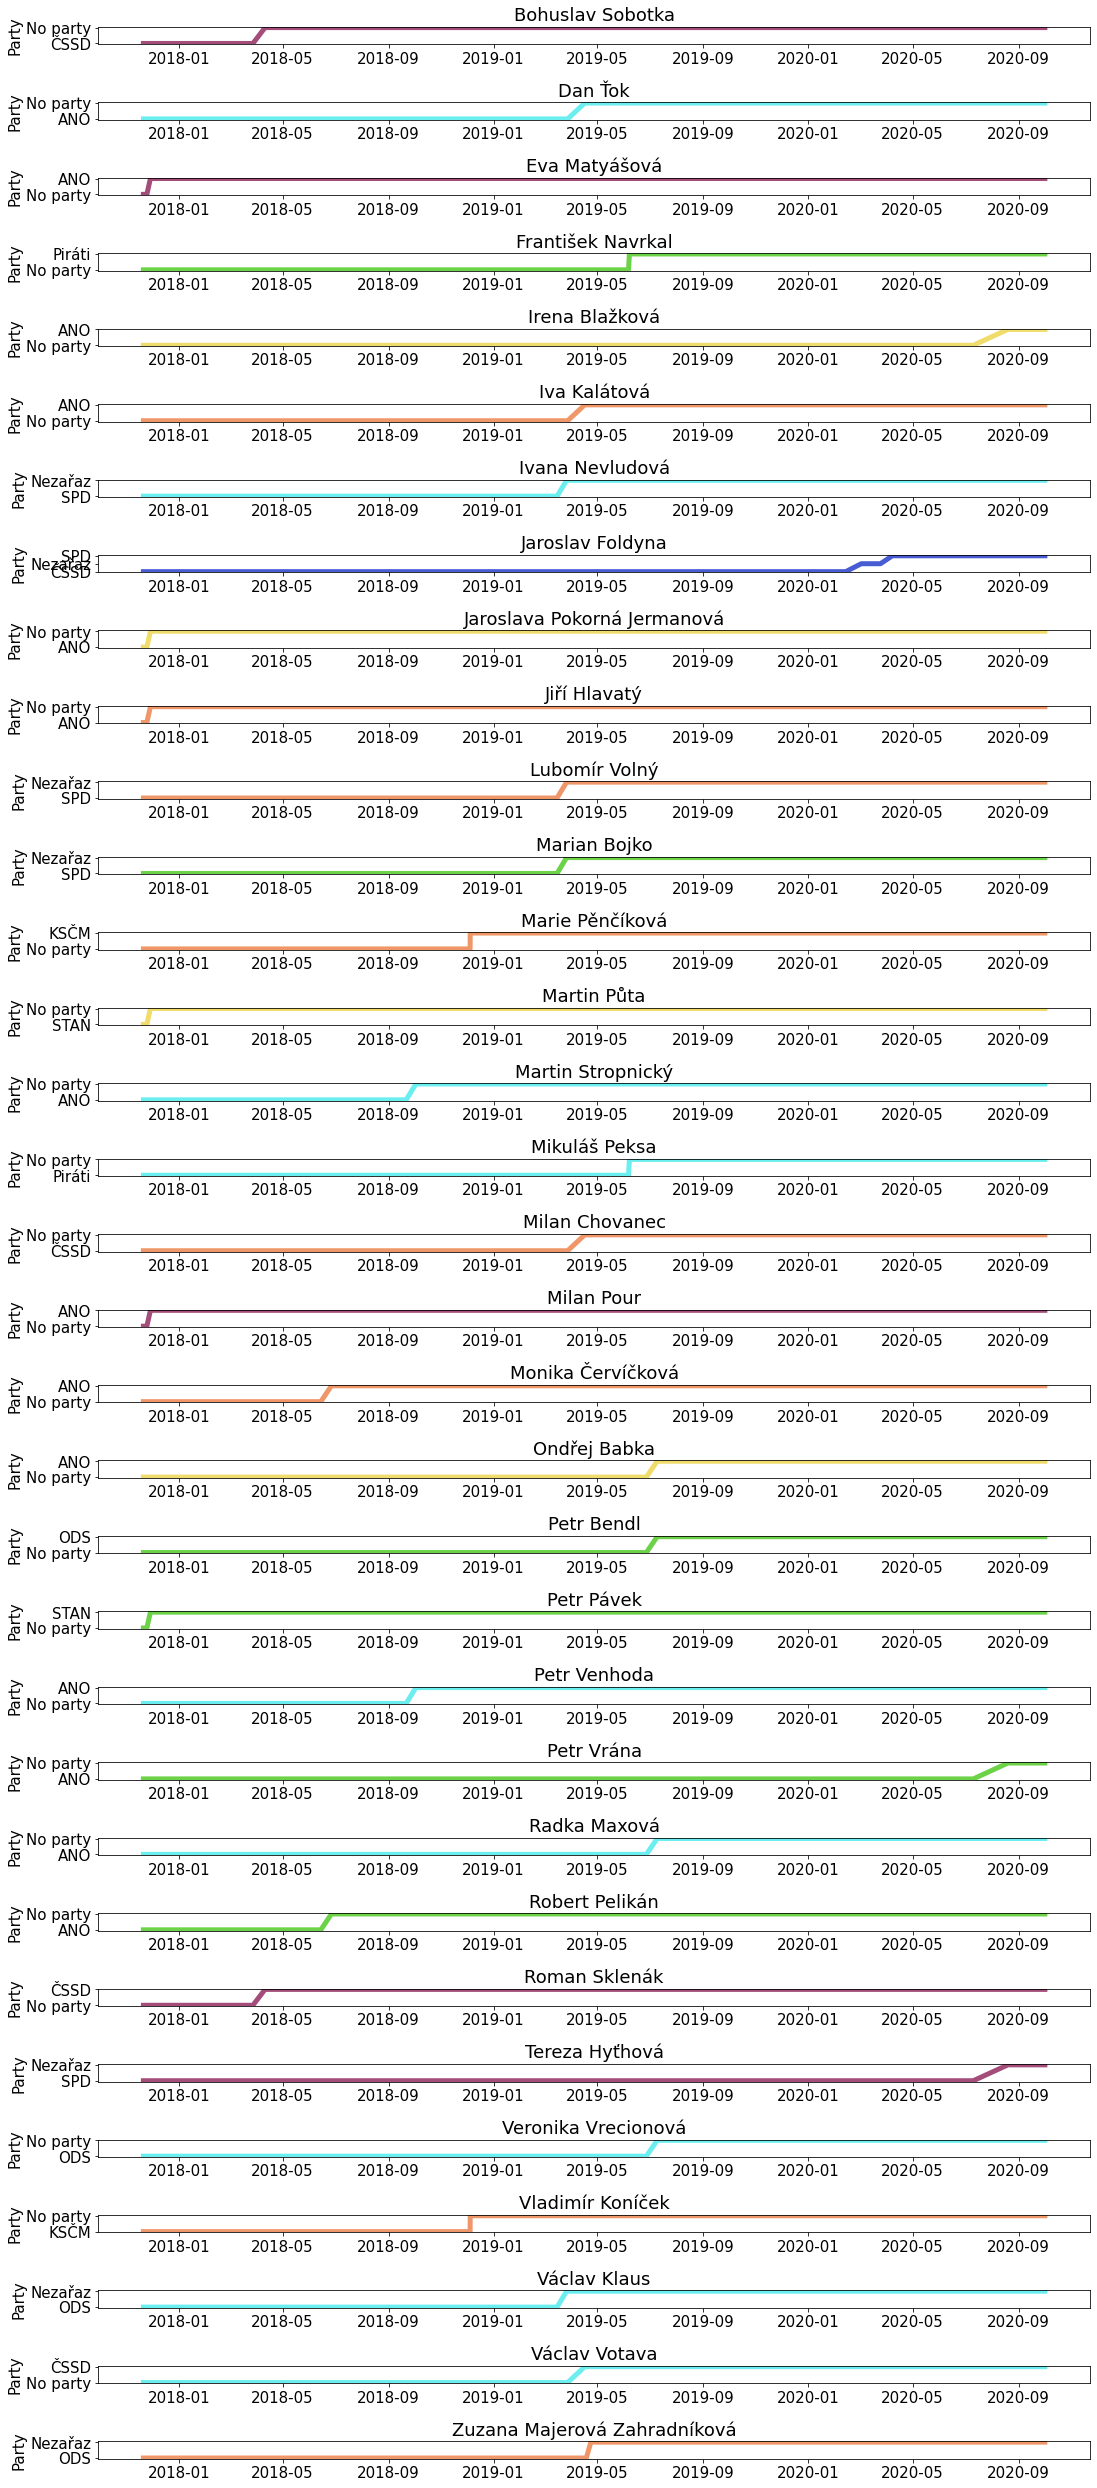

In [28]:
fig, plots = plt.subplots(len(plot_1_data.index), figsize=(15, 35))
plt.tight_layout(pad=2)

for num, (row_name, row) in enumerate(plot_1_data.iterrows()):
    plots[num].plot(row.index.values, row, linestyle='-', linewidth=5, c=np.random.choice(color_samples))
    plots[num].set_title(row_name)
    plots[num].set_ylabel("Party")
    
plt.show()

As we can see above for the big part of voters, the part of plot between the parties' activities is pretty slope. So we can assume that the process of changing the political party is not fast.

Here is **the other attempt of visualizing that data**, but it is not so successful as the plots overlap and we can't see every voter's path on it (even **showing the 25% of the voters**):

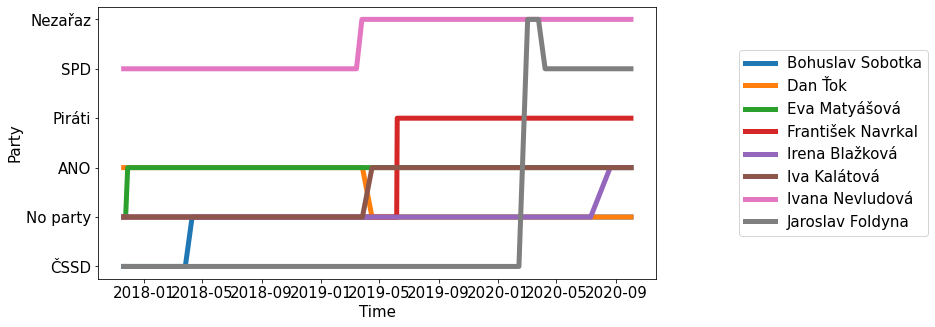

In [29]:
fig, plot = plt.subplots(figsize=(10, 5))

for _, row in plot_1_data[:len(plot_1_data.index) // 4].iterrows():
    plot.plot(row.index.values, row, linestyle='-', linewidth=5)
plot.legend(plot_1_data[:len(plot_1_data.index) // 4].index, loc=5, bbox_to_anchor=(1.5, 0.5))
plot.set_xlabel("Time")
plot.set_ylabel("Party")
    
plt.show()

On the next two bar plots I showed **the percentage of missed votings by single voters** and then **by parties**:
* To visualize this data, I created a new dataset with the numerical information inside it;
* firstly, I counted the votings missed by the voters and then all votings they participated in;
* then I needed to group the voters by name not to make mistakes in those cases, where one voter voted for more than one party;
* finally, I computed the percentage of the missed votings and sorted it for the better understanding.

In [30]:
plot_2_data = pd.DataFrame(index=data.index)
plot_2_data["Missed votings"] = data[(data == "0") | (data == "M")].count(axis=1)
plot_2_data["All votings"] = len(data.columns) - data.isna().sum(axis=1)
plot_2_data.index = plot_2_data.index.map(lambda x: x.split("@")[0])
plot_2_data = plot_2_data.groupby(plot_2_data.index).sum()
plot_2_data["Percentage"] = plot_2_data["Missed votings"] / plot_2_data["All votings"]
plot_2_data.sort_values(by="Percentage", inplace=True)
display(plot_2_data)

,Missed votings,All votings,Percentage
Jiří Hlavatý,0,16,0.000000
Martin Půta,0,16,0.000000
Radek Rozvoral,28,6934,0.004038
Lukáš Bartoň,30,6934,0.004327
Miloslav Rozner,42,6934,0.006057
...,...,...,...
Jan Hamáček,3798,6934,0.547736
Martin Stropnický,708,1210,0.585124
Jana Levová,4167,6934,0.600952
Karel Schwarzenberg,4825,6934,0.695847


And here comes **the bar plot for voters**...

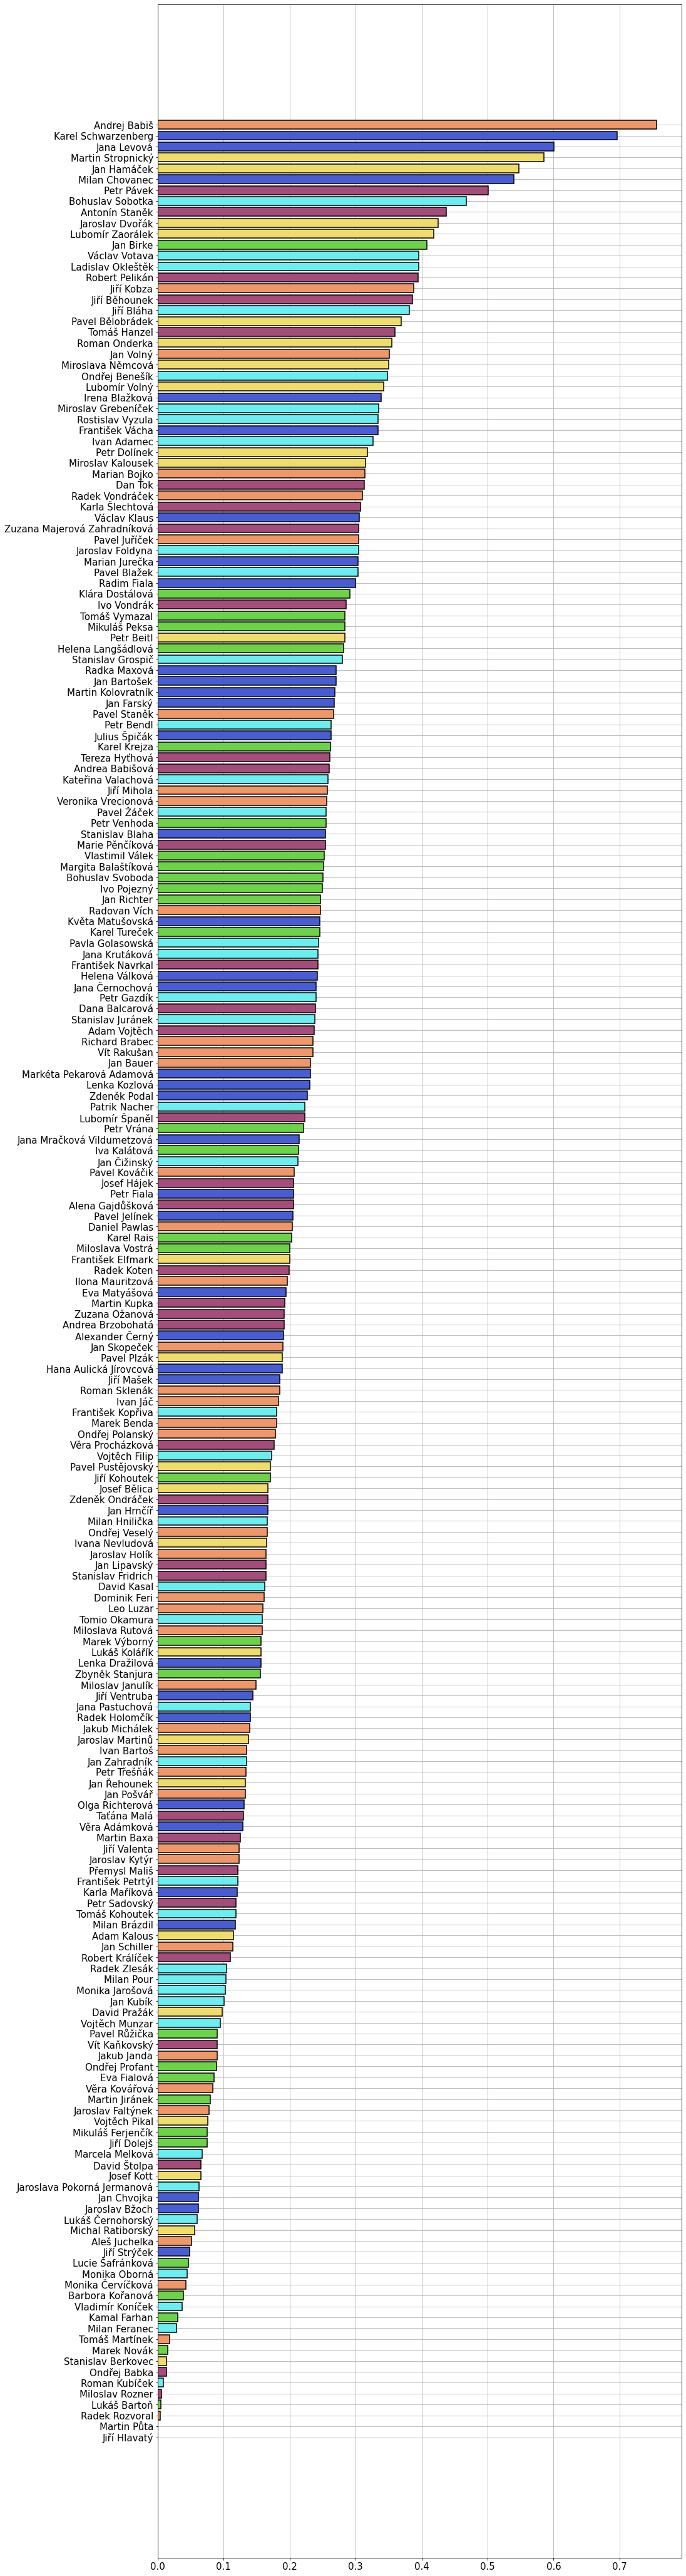

In [31]:
fig, ax = plt.subplots(figsize=(15, 75))

ax.barh([row_name.split("@")[0] for row_name in plot_2_data.index], plot_2_data["Percentage"],
        color=np.random.choice(color_samples, len(plot_2_data.index)), edgecolor='k', linewidth=1.5)
ax.set_axisbelow(True)
plt.grid()
plt.show()

The process of counting **the percentage of missed votings for parties** is similar, but in this case I needed to group the rows by the party names, as the voters' names didn't play a role here:

In [35]:
plot_3_data = pd.DataFrame(index=data.index)
plot_3_data["Missed votings"] = data[(data == "0") | (data == "M")].count(axis=1)
plot_3_data["All votings"] = len(data.columns) - data.isna().sum(axis=1)
plot_3_data.index = plot_3_data.index.map(lambda x: x.split("@")[1])
plot_3_data = plot_3_data.groupby(plot_3_data.index).sum()
plot_3_data["Percentage"] = plot_3_data["Missed votings"] / plot_3_data["All votings"]
plot_3_data.sort_values(by="Percentage", inplace=True)
display(plot_3_data)

,Missed votings,All votings,Percentage
Piráti,21572,152548,0.141411
ANO,94048,540852,0.173889
KSČM,20825,104010,0.200221
SPD,29391,140110,0.209771
ODS,34925,164461,0.212360
KDU-ČSL,17262,69340,0.248947
STAN,10880,41604,0.261513
ČSSD,32961,102348,0.322048
TOP09,15752,48538,0.324529
Nezařaz,8044,22989,0.349906


Here is **the plot**:

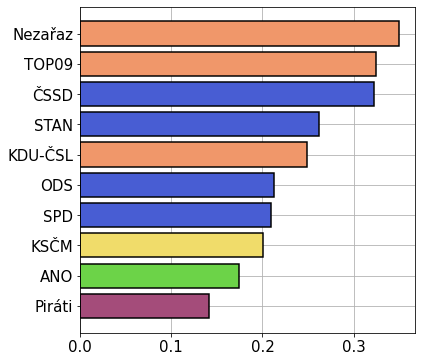

In [36]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.barh([row_name.split("@")[0] for row_name in plot_3_data.index], plot_3_data["Percentage"],
        color=np.random.choice(color_samples, len(plot_3_data.index)), edgecolor='k', linewidth=1.5)
ax.set_axisbelow(True)
plt.grid()
plt.show()

Next, to visualize **the similarity of parties' decisions** on the votings I needed to count all its members' votes and choose the most frequent one. Then I computed the percentage of the same decisions for every pair of parties and saved that data to the diagonally symmetrical matrix.

In [37]:
party_decisions = data.copy()
party_decisions.index = party_decisions.index.map(lambda x: x.split("@")[1])
party_decisions = party_decisions.groupby(party_decisions.index).apply(
    lambda x: pd.Series([max(set(x[y]), key=list(x[y]).count) for y in x], 
                         name=x.name, index=x.columns))

parties = set(data.index.map(lambda x: x.split("@")[1]))
plot_4_data = pd.DataFrame(index=parties, columns=parties)
for row_name, row in plot_4_data.iterrows():
    for col_name in row.index:
        all_decisions = len(party_decisions.loc[[row_name, col_name]].dropna(axis=1).columns)
        same_decisions = (party_decisions.loc[row_name] == party_decisions.loc[col_name]).astype(int).sum()
        plot_4_data[col_name].loc[row_name] = same_decisions / all_decisions
plot_4_data = plot_4_data.astype(float)
        
display(plot_4_data)

,ANO,ČSSD,Piráti,KSČM,TOP09,KDU-ČSL,ODS,Nezařaz,SPD,STAN
ANO,1.000000,0.692385,0.457889,0.757860,0.429766,0.446351,0.453274,0.395098,0.519037,0.413037
ČSSD,0.692385,1.000000,0.401067,0.648832,0.422700,0.442746,0.408134,0.393137,0.432218,0.402798
Piráti,0.457889,0.401067,1.000000,0.435679,0.683877,0.724978,0.694693,0.615686,0.655033,0.709836
KSČM,0.757860,0.648832,0.435679,1.000000,0.416210,0.435968,0.446351,0.426225,0.527690,0.400346
TOP09,0.429766,0.422700,0.683877,0.416210,1.000000,0.697289,0.702336,0.610784,0.634266,0.718489
KDU-ČSL,0.446351,0.442746,0.724978,0.435968,0.697289,1.000000,0.736372,0.612990,0.658062,0.731757
ODS,0.453274,0.408134,0.694693,0.446351,0.702336,0.736372,1.000000,0.660049,0.691087,0.718921
Nezařaz,0.395098,0.393137,0.615686,0.426225,0.610784,0.612990,0.660049,1.000000,0.718382,0.611029
SPD,0.519037,0.432218,0.655033,0.527690,0.634266,0.658062,0.691087,0.718382,1.000000,0.629651
STAN,0.413037,0.402798,0.709836,0.400346,0.718489,0.731757,0.718921,0.611029,0.629651,1.000000


The best way to visualize that matrix was drawing **a heatmap**, where the color scheme reflects how similar were the parties' decisions.

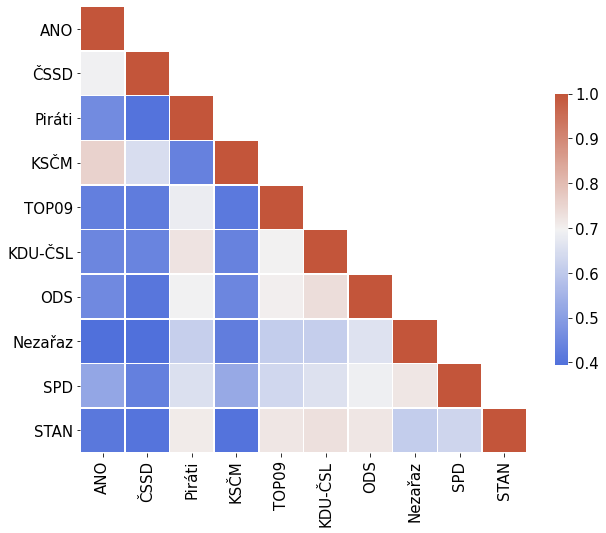

In [38]:
fig, ax = plt.subplots(figsize=(10, 10))

cmap = sns.diverging_palette(260, 20, as_cmap=True)
mask = np.triu(plot_4_data, 1)
sns.heatmap(plot_4_data, mask=mask, cmap=cmap, square=True, linewidths=0.5, cbar_kws={"shrink": .5})

plt.show()

To emphasize **the similarity of voters' decisions inside the distinct parties**, I needed to define a function that computes **the entropy** for columns in a dataset. With that entropy I could easily understand how similar were parties members' votes on every voting.

In [39]:
def entropy(values):
    values = values.replace(0, "0")
    ents = np.zeros(len(values.columns))
    for num, col_name in enumerate(values.columns):
        _, counts = np.unique(values[col_name].dropna(), return_counts=True)
        probs = counts / len(values.index)
        if np.count_nonzero(probs) <= 1:
            ents[num] = 0
        else:
            for prob in probs:
                ents[num] -= prob * math.log(prob)
    return pd.Series(ents, index=values.columns)
    

plot_5_data = data.copy()
plot_5_data.index = plot_5_data.index.map(lambda x: x.split("@")[1])
plot_5_data = plot_5_data.groupby(plot_5_data.index).apply(entropy)
plot_5_data.columns = pd.to_datetime([reformat_datetime(col_name.split("@")[2]) 
                                      for col_name in plot_5_data.columns], format="%d-%m-%Y %H:%M")
display(plot_5_data)

,2017-11-20 13:53:00,2017-11-20 13:53:00,2017-11-20 14:47:00,2017-11-20 15:39:00,2017-11-20 15:39:00,2017-11-22 10:06:00,2017-11-22 12:57:00,2017-11-22 13:00:00,2017-11-22 17:23:00,2017-11-22 17:24:00,...,2020-10-01 13:56:00,2020-10-01 13:56:00,2020-10-01 13:57:00,2020-10-01 13:58:00,2020-10-01 13:59:00,2020-10-01 13:59:00,2020-10-01 14:00:00,2020-10-01 14:01:00,2020-10-01 14:02:00,2020-10-01 14:03:00
ANO,0.297099,0.250928,0.204601,0.141809,0.141809,0.000000,0.000000,0.228463,0.624616,0.204601,...,0.823117,0.769643,0.824046,0.964633,0.964633,0.973153,0.943717,0.861823,0.769643,0.915581
KDU-ČSL,0.325083,0.325083,0.000000,0.000000,0.000000,0.500402,0.000000,0.000000,0.000000,1.088900,...,0.610864,0.610864,0.610864,0.610864,0.610864,0.610864,0.610864,0.610864,0.610864,0.801819
KSČM,0.290127,0.290127,0.813613,0.860414,0.290127,0.290127,0.000000,0.000000,0.708245,0.000000,...,0.657237,0.657237,0.657237,0.657237,0.657237,0.657237,0.657237,0.657237,0.813613,0.744759
Nezařaz,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ODS,0.199197,0.000000,0.546985,0.997206,0.000000,0.000000,0.359079,0.000000,0.199197,0.822251,...,0.571628,0.571628,0.571628,0.571628,0.571628,0.571628,0.571628,0.571628,0.571628,0.571628
Piráti,0.000000,0.000000,0.000000,0.000000,0.496044,0.394184,0.000000,0.394184,0.000000,0.000000,...,0.705529,0.705529,0.705529,0.705529,0.705529,0.705529,0.851225,0.705529,0.705529,0.842912
SPD,0.000000,0.000000,0.394184,0.669502,0.000000,0.000000,0.000000,0.000000,0.000000,0.555176,...,0.790559,0.790559,0.790559,0.790559,0.790559,0.790559,0.790559,0.790559,0.790559,0.899342
STAN,0.000000,0.000000,0.518324,0.518324,0.000000,0.000000,0.000000,0.000000,0.000000,0.518324,...,0.677713,0.677713,0.677713,0.677713,0.677713,0.677713,0.677713,0.677713,0.677713,0.677713
TOP09,0.000000,0.000000,0.796312,0.410116,0.410116,0.410116,0.796312,0.410116,0.682908,1.277034,...,0.410116,0.410116,0.410116,0.410116,0.410116,0.410116,0.410116,0.410116,0.410116,0.410116
ČSSD,0.456916,0.326553,0.966423,1.067957,0.326553,0.951560,0.754442,1.061238,1.277746,0.870013,...,0.696634,0.696634,0.894578,0.843811,0.894578,0.843811,0.894578,0.696634,0.843811,0.894578


Having that data, I could easily visualize it. On the plots below we can see that the entropy was not the same always. It distributes between 0 and approximately 1.4, where 0 means that the majority of voters unanimously made the decision and with the growth of entropy the votes become more evenly distributed. I also decided to show only the votings starting on the January 1., 2020, to get the better understanding of the entropy distributions.

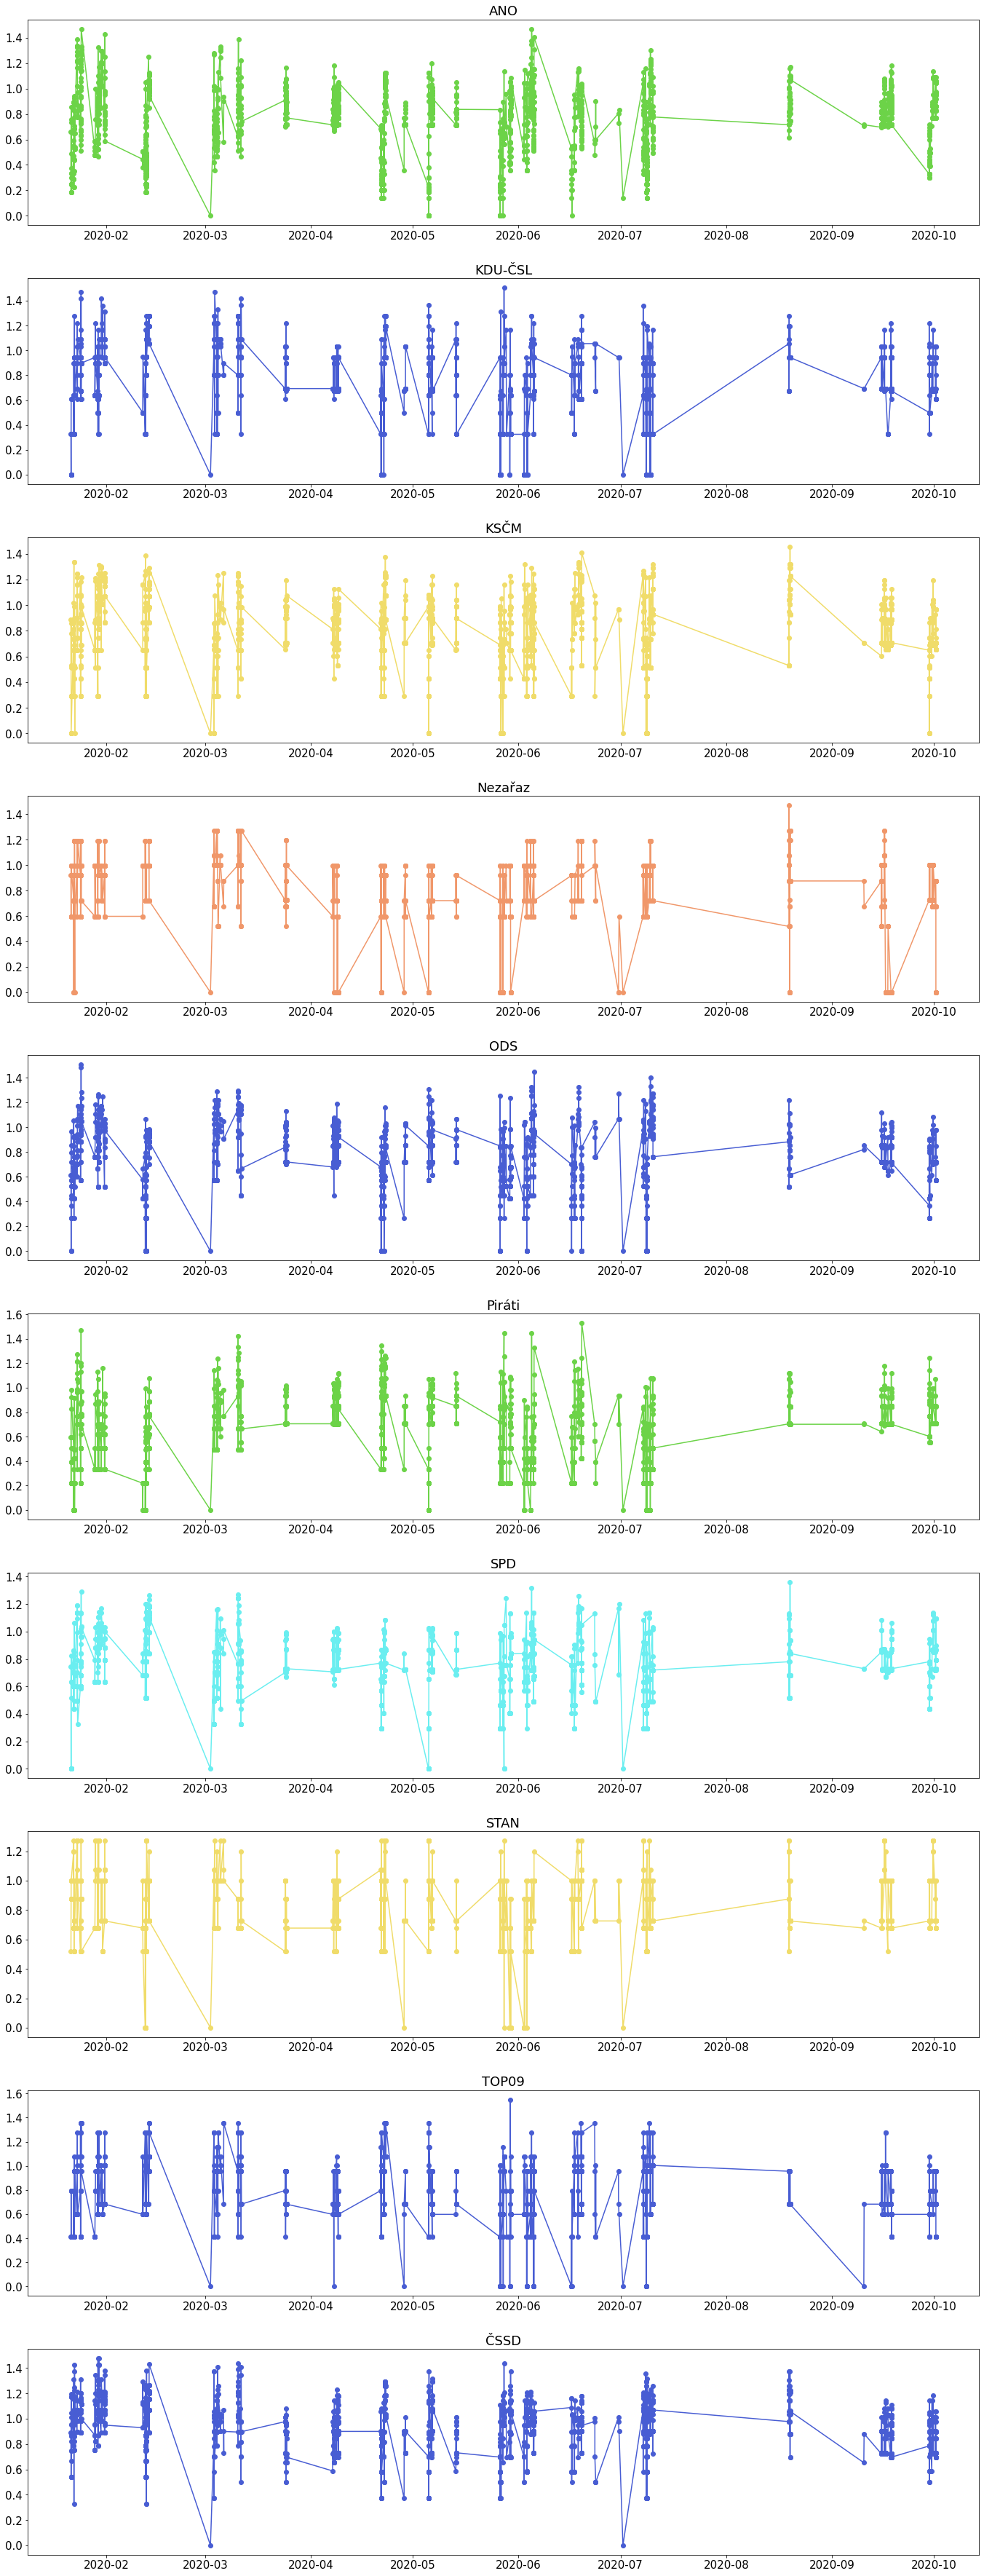

In [40]:
fig, axs = plt.subplots(len(plot_5_data.index), figsize=(20, 50))
plt.tight_layout(pad=3)

start_date = pd.to_datetime("01-01-2020", format="%d-%m-%Y")
for num, (row_name, row) in enumerate(plot_5_data.iterrows()):
    new_row = row[row.index >= start_date]
    axs[num].plot(new_row.index, new_row, c=np.random.choice(color_samples), marker='o')
    axs[num].set_title(row_name)
    
plt.show()

Another method of computing the variance of votes was finding **the sum of squares** of the differences between real counts of votes and their average value. On both plots (above and below) we can see, that the variance for every party's votes changes a lot, so we can't surely tell if the voters had always the same opinions. The vertical group of dots shown on these plots emphasize the votings of distinct sessions (meetings). 

In [41]:
def square_sum(values):
    values = values.replace(0, "0")
    sums = np.zeros(len(values.columns))
    for num, col_name in enumerate(values.columns):
        unique, counts = np.unique(values[col_name].dropna(), return_counts=True)
        if len(unique) == 0:
            sums[num] = 0
        else:
            avg = len(values[col_name]) / len(unique)
            sums[num] = ((counts - avg) ** 2).sum()
    return pd.Series(sums, index=values.columns)
    

plot_6_data = data.copy()
plot_6_data.index = plot_6_data.index.map(lambda x: x.split("@")[1])
plot_6_data = plot_6_data.groupby(plot_6_data.index).apply(square_sum)
plot_6_data.columns = pd.to_datetime([reformat_datetime(col_name.split("@")[2]) 
                                      for col_name in plot_6_data.columns], format="%d-%m-%Y %H:%M")
display(plot_6_data)

,2017-11-20 13:53:00,2017-11-20 13:53:00,2017-11-20 14:47:00,2017-11-20 15:39:00,2017-11-20 15:39:00,2017-11-22 10:06:00,2017-11-22 12:57:00,2017-11-22 13:00:00,2017-11-22 17:23:00,2017-11-22 17:24:00,...,2020-10-01 13:56:00,2020-10-01 13:56:00,2020-10-01 13:57:00,2020-10-01 13:58:00,2020-10-01 13:59:00,2020-10-01 13:59:00,2020-10-01 14:00:00,2020-10-01 14:01:00,2020-10-01 14:02:00,2020-10-01 14:03:00
ANO,3472.333333,3618.333333,3766.333333,2912.500000,2912.5,49.00,49.000000,2616.50,3209.00,3766.333333,...,1389.25,954.333333,1383.250000,1073.250000,1073.250000,1421.000000,1127.250000,1313.25,954.333333,1545.000000
KDU-ČSL,32.000000,32.000000,0.000000,0.000000,0.0,18.00,0.000000,0.00,0.00,0.666667,...,8.00,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.00,8.000000,20.666667
KSČM,85.000000,85.000000,42.333333,32.333333,85.0,85.00,1.000000,1.00,1.00,1.000000,...,13.00,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.00,42.333333,56.333333
Nezařaz,0.000000,0.000000,0.000000,0.000000,0.0,0.00,0.000000,0.00,0.00,0.000000,...,1.00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00,1.000000,1.000000
ODS,265.000000,1.000000,243.000000,41.000000,1.0,1.00,323.000000,1.00,265.00,195.000000,...,89.00,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.00,89.000000,89.000000
Piráti,1.000000,1.000000,1.000000,1.000000,98.5,241.00,1.000000,241.00,1.00,1.000000,...,0.50,0.500000,0.500000,0.500000,0.500000,0.500000,61.000000,0.50,0.500000,65.000000
SPD,1.000000,1.000000,241.000000,18.500000,1.0,1.00,1.000000,1.00,1.00,72.500000,...,80.00,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.00,80.000000,100.750000
STAN,1.000000,1.000000,8.500000,8.500000,1.0,1.00,1.000000,1.00,1.00,8.500000,...,2.50,2.500000,2.500000,2.500000,2.500000,2.500000,2.500000,2.50,2.500000,2.500000
TOP09,0.000000,0.000000,10.666667,12.500000,12.5,12.50,10.666667,12.50,0.50,2.750000,...,12.50,12.500000,12.500000,12.500000,12.500000,12.500000,12.500000,12.50,12.500000,12.500000
ČSSD,62.500000,86.500000,19.333333,3.333333,86.5,55.75,57.333333,39.75,7.75,39.333333,...,12.50,12.500000,31.666667,35.666667,31.666667,35.666667,31.666667,12.50,35.666667,31.666667


Here is the secong plot that visualizes the data computed by using **the sum of squares method**. We can see, that the plots aren't really different, which tells us, that both methods can be successfully used for this problem.

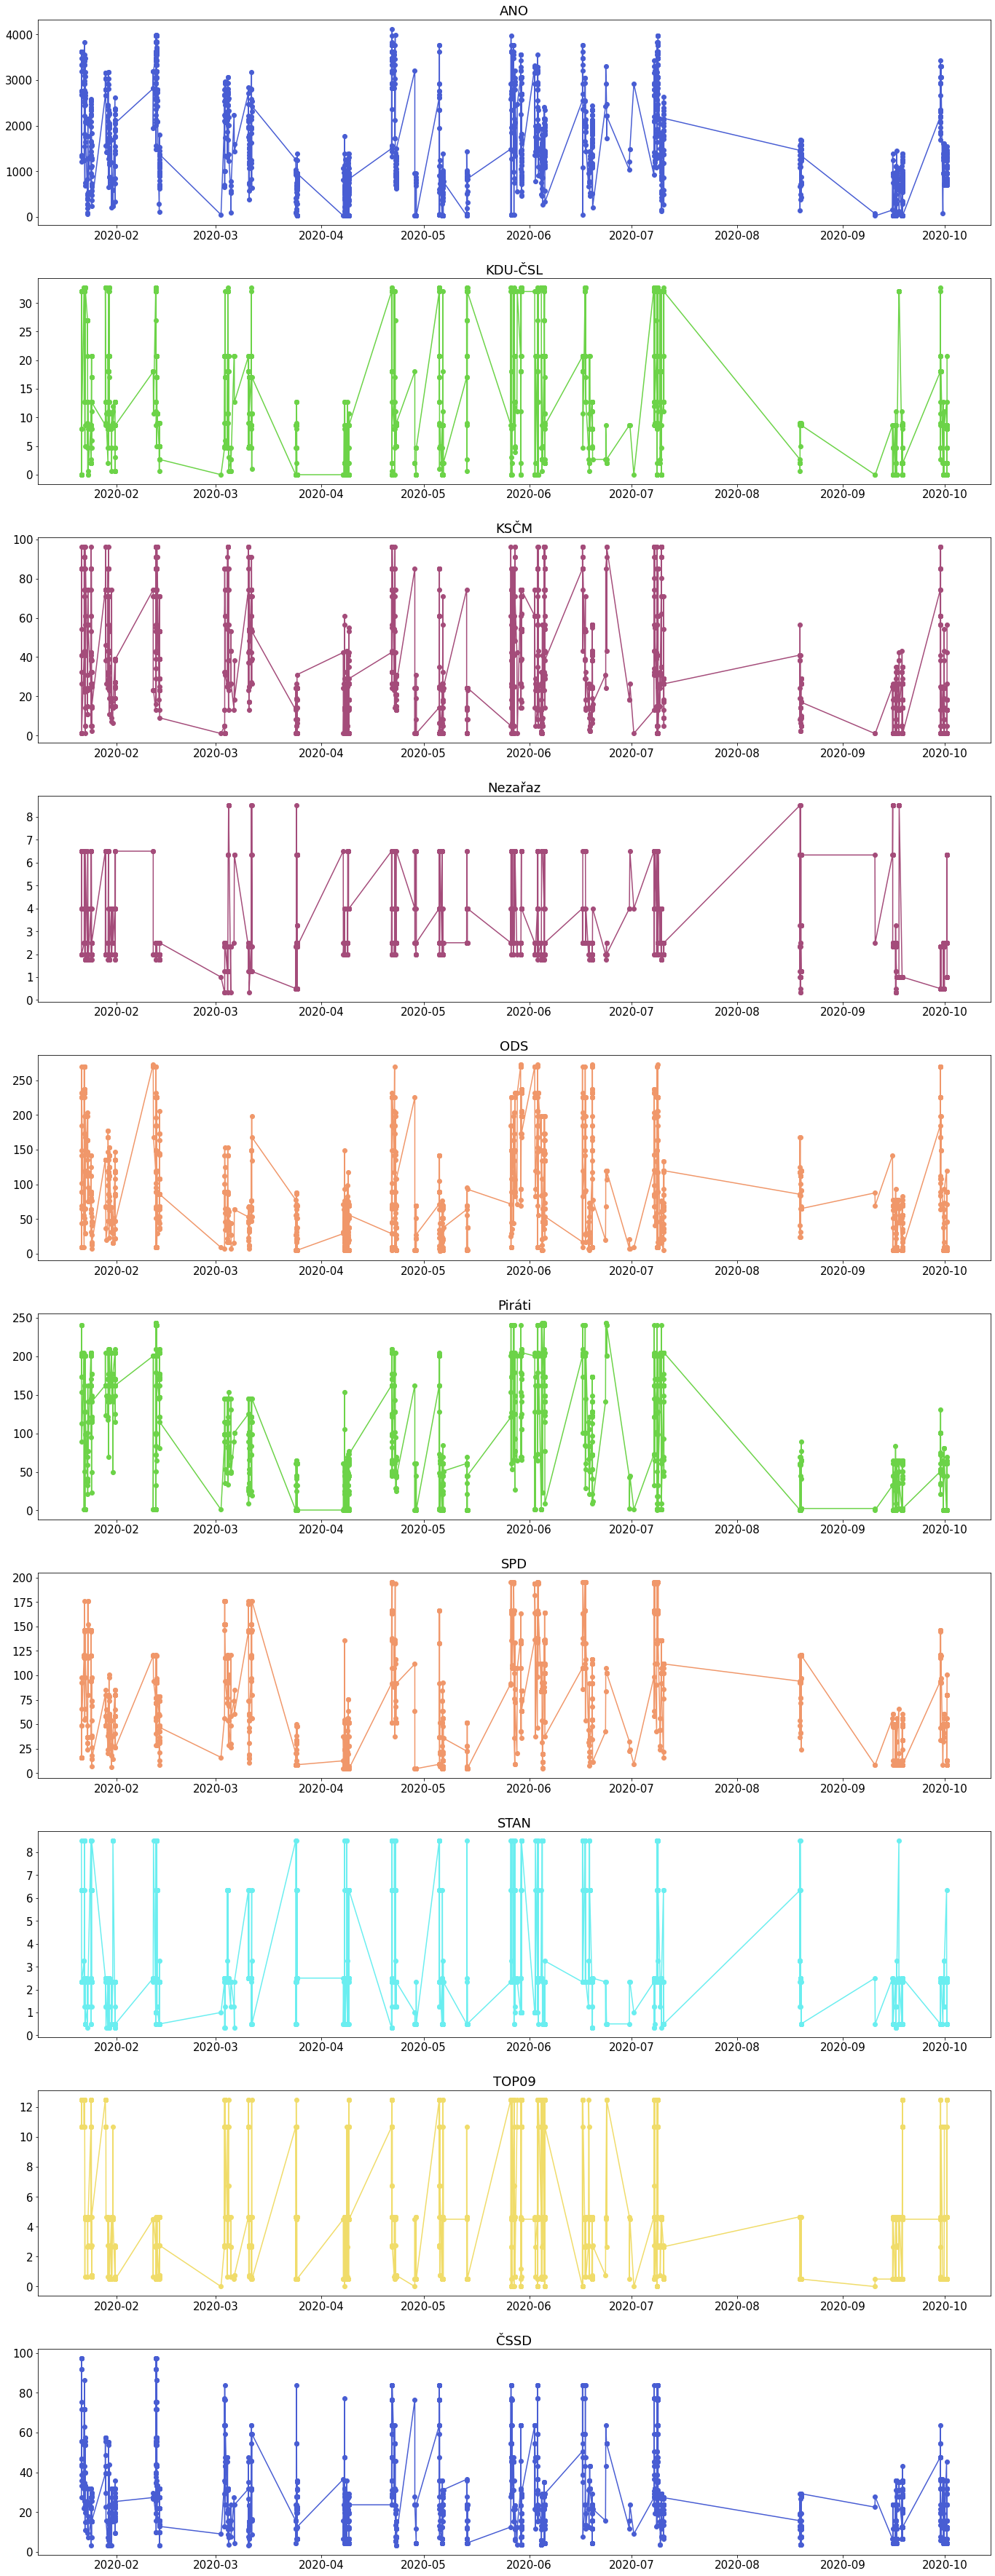

In [42]:
fig, axs = plt.subplots(len(plot_6_data.index), figsize=(20, 50))
plt.tight_layout(pad=3)

start_date = pd.to_datetime("01-01-2020", format="%d-%m-%Y")
for num, (row_name, row) in enumerate(plot_6_data.iterrows()):
    new_row = row[row.index >= start_date]
    axs[num].plot(new_row.index, new_row, c=np.random.choice(color_samples), marker='o')
    axs[num].set_title(row_name)
    
plt.show()

The next bar plot is determined to show the voters, that had **the most and least similar opinions comparing to their parties' ones**. Here for every voter I counted the percentage of the same votes (as their parties) he or she had and used it for the visualization.

In [43]:
plot_7_data = data.copy()
plot_7_data.index = plot_7_data.index.map(lambda x: tuple(x.split("@")))
plot_7_data = dict(tuple(plot_7_data.groupby(lambda x: x[1])))
for party in plot_7_data.keys():
    plot_7_data[party].index = plot_7_data[party].index.map(lambda x: x[0])
    plot_7_data[party] = plot_7_data[party].apply(
        (lambda x: (x == party_decisions.loc[party]).astype(int).sum() / \
                    x.count()), axis=1).sort_values()
print(plot_7_data)

{'ANO': Andrej Babiš                   0.291030
Martin Stropnický              0.364463
Radek Vondráček                0.496106
Patrik Nacher                  0.554081
Robert Pelikán                 0.558723
                                 ...   
Jiří Strýček                   0.876695
František Petrtýl              0.891260
Stanislav Fridrich             0.901933
Jiří Hlavatý                   0.937500
Jaroslava Pokorná Jermanová    0.937500
Length: 85, dtype: float64, 'KDU-ČSL': Pavel Bělobrádek     0.603692
Ondřej Benešík       0.616527
Marian Jurečka       0.624459
Jan Bartošek         0.681569
Jiří Mihola          0.716758
Jan Čižinský         0.726276
Pavla Golasowská     0.741852
Stanislav Juránek    0.762475
Marek Výborný        0.799971
Vít Kaňkovský        0.841938
dtype: float64, 'KSČM': Jiří Dolejš               0.598500
Stanislav Grospič         0.618835
Vojtěch Filip             0.636862
Pavel Kováčik             0.651139
Miroslav Grebeníček       0.677098
Miloslava Vost

And here come **the bar plots** of sorted values, where we can easily see how the voters agree with their parties.

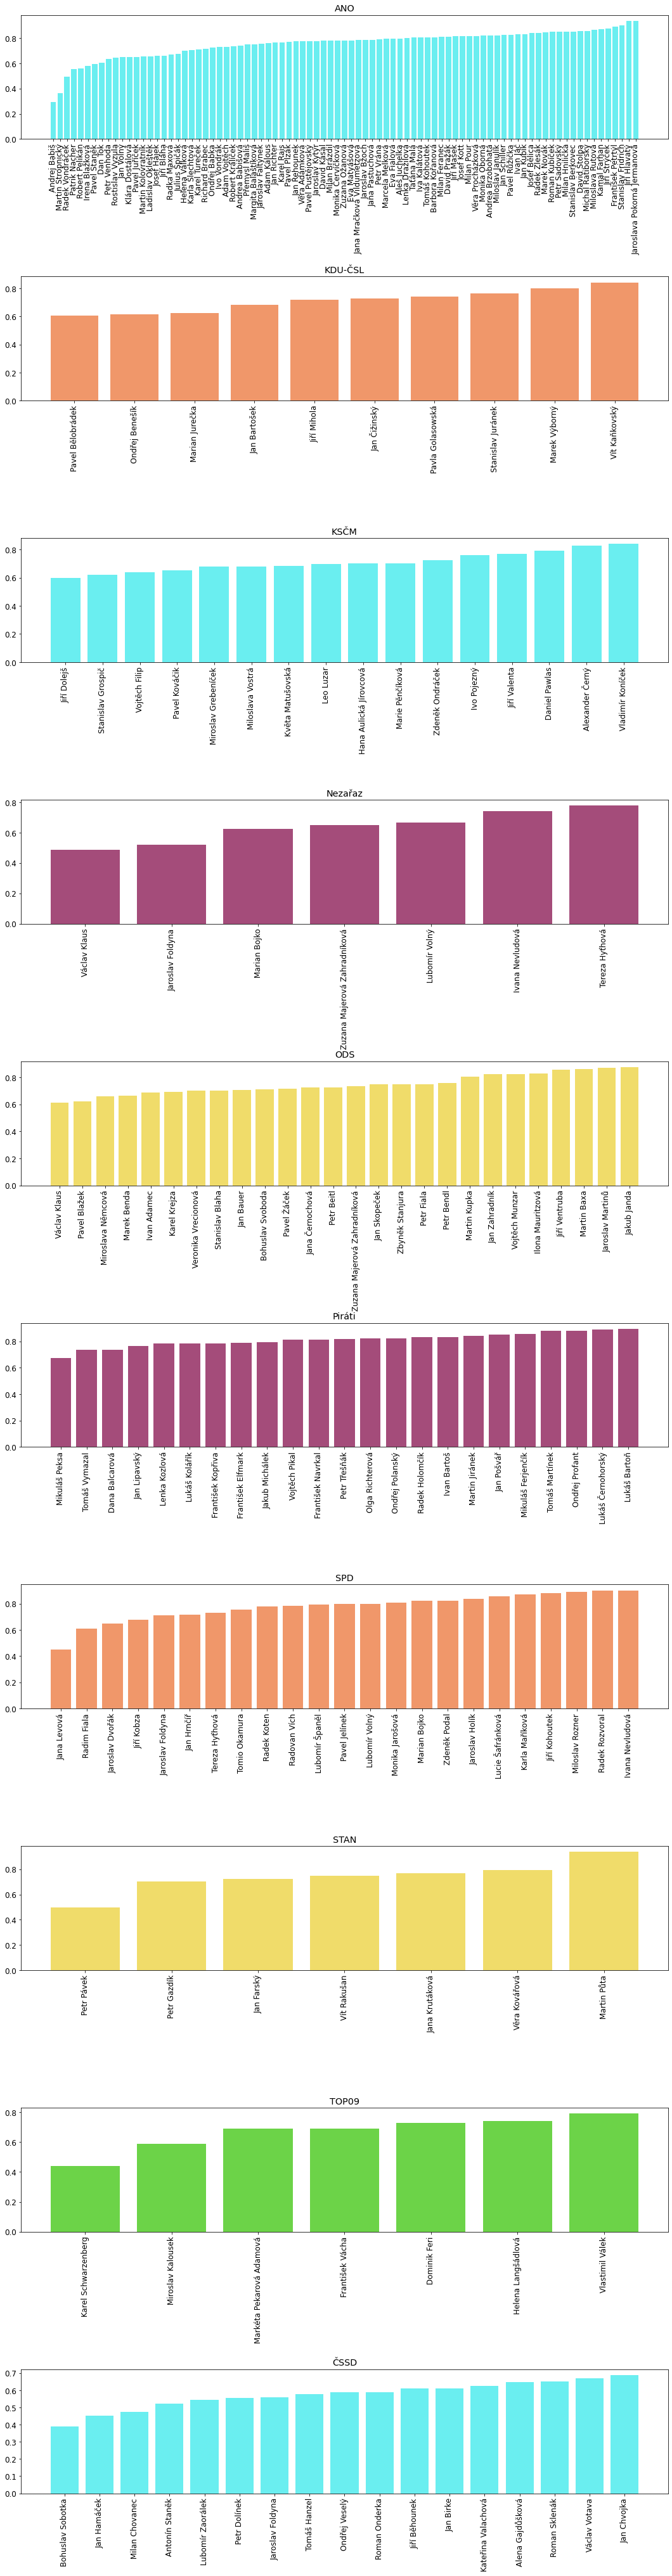

In [44]:
plt.rcParams.update({'font.size': 12})
fig, axs = plt.subplots(len(plot_7_data), figsize=(20, 60))
plt.tight_layout(pad=16)

for num, party in enumerate(plot_7_data.keys()):
    axs[num].bar(plot_7_data[party].index, plot_7_data[party], color=np.random.choice(color_samples))
    axs[num].set_title(party)
    plt.sca(axs[num])
    plt.xticks(rotation=90)    
plt.show()

Here is my attempt to solve **the additional task**. I tried to find **the voters that made the most similar decisions** during the votings. I filtered the resulting matrix so that it has data only about the voters that have that relationship to at least 10 another voters. I also filtered out the candidates that had the percentage of similarity lower than 80%. **(CAREFUL: this cell runs for a long time, as the number of cycle iterations is more than 200 * 200 = 40,000)**

In [45]:
MIN_COUNT = 10
MIN_SIMILARITY = .8

plot_8_data = pd.DataFrame()
for col_name in data.index:
    new_col = {}
    for row_name in data.index:
        voter_1, voter_2 = data.loc[col_name], data.loc[row_name]
        similarity = ((voter_1 == voter_2).astype(int).sum()) / ((~voter_1.isna() & ~voter_2.isna()).astype(int).sum())
        new_col[row_name] = similarity
    if len([val for val in new_col.values() if val >= MIN_SIMILARITY]) >= MIN_COUNT:
        plot_8_data = pd.concat([plot_8_data, pd.Series(new_col, name=col_name)], axis="columns")

plot_8_data.drop(index=[row_name for row_name in plot_8_data.index 
        if (plot_8_data.loc[row_name] >= MIN_SIMILARITY).astype(int).sum() < MIN_COUNT], inplace=True)
plot_8_data.drop(columns=[col_name for col_name in plot_8_data.columns 
        if (plot_8_data[col_name] >= MIN_SIMILARITY).astype(int).sum() < MIN_COUNT], inplace=True)
plot_8_data.index = plot_8_data.index.map(lambda x: x.split("@")[0] + " - " + x.split("@")[1])
plot_8_data.columns = plot_8_data.columns.map(lambda x: x.split("@")[0] + " - " + x.split("@")[1])
display(plot_8_data)

<ipython-input-45-e8d88d3ec5f0>:9: RuntimeWarning: invalid value encountered in long_scalars
  similarity = ((voter_1 == voter_2).astype(int).sum()) / ((~voter_1.isna() & ~voter_2.isna()).astype(int).sum())


,Stanislav Berkovec - ANO,Kamal Farhan - ANO,Milan Feranec - ANO,Jiří Hlavatý - ANO,Aleš Juchelka - ANO,Barbora Kořanová - ANO,Roman Kubíček - ANO,Marcela Melková - ANO,Marek Novák - ANO,Monika Oborná - ANO,Jaroslava Pokorná Jermanová - ANO,David Pražák - ANO,Michal Ratiborský - ANO,Jiří Strýček - ANO,David Štolpa - ANO,Ondřej Babka - ANO
Stanislav Berkovec - ANO,1.000000,0.898471,0.857802,0.9375,0.831266,0.854197,0.899337,0.860542,0.898327,0.869051,0.9375,0.832708,0.856360,0.881598,0.867032,0.880574
Kamal Farhan - ANO,0.898471,1.000000,0.850591,0.9375,0.838766,0.840785,0.903807,0.838189,0.890828,0.877127,0.9375,0.824055,0.856937,0.880300,0.875252,0.850327
Milan Feranec - ANO,0.857802,0.850591,1.000000,0.9375,0.781944,0.809057,0.850303,0.810499,0.843813,0.829824,0.9375,0.786703,0.812518,0.830257,0.814537,0.816651
Jiří Hlavatý - ANO,0.937500,0.937500,0.937500,1.0000,0.937500,0.937500,0.937500,0.937500,0.937500,0.937500,0.9375,0.937500,0.937500,0.937500,0.875000,NaN
Aleš Juchelka - ANO,0.831266,0.838766,0.781944,0.9375,1.000000,0.812518,0.840063,0.786992,0.828959,0.808192,0.9375,0.765936,0.793337,0.817133,0.804153,0.801996
Barbora Kořanová - ANO,0.854197,0.840785,0.809057,0.9375,0.812518,1.000000,0.856648,0.794924,0.849149,0.829103,0.9375,0.769541,0.813960,0.839631,0.813960,0.819457
Roman Kubíček - ANO,0.899337,0.903807,0.850303,0.9375,0.840063,0.856648,1.000000,0.833574,0.890684,0.886213,0.9375,0.814393,0.860542,0.894722,0.870782,0.867166
Marcela Melková - ANO,0.860542,0.838189,0.810499,0.9375,0.786992,0.794924,0.833574,1.000000,0.839919,0.815979,0.9375,0.786992,0.793337,0.815547,0.800981,0.811974
Marek Novák - ANO,0.898327,0.890828,0.843813,0.9375,0.828959,0.849149,0.890684,0.839919,1.000000,0.866888,0.9375,0.817133,0.853043,0.870782,0.861840,0.855005
Monika Oborná - ANO,0.869051,0.877127,0.829824,0.9375,0.808192,0.829103,0.886213,0.815979,0.866888,1.000000,0.9375,0.800981,0.835160,0.873810,0.834872,0.845338


As drawing **a heatmap** is the best method of visualization of **diagonally symmetrical matrices**, I decided to choose it. Here is the result:

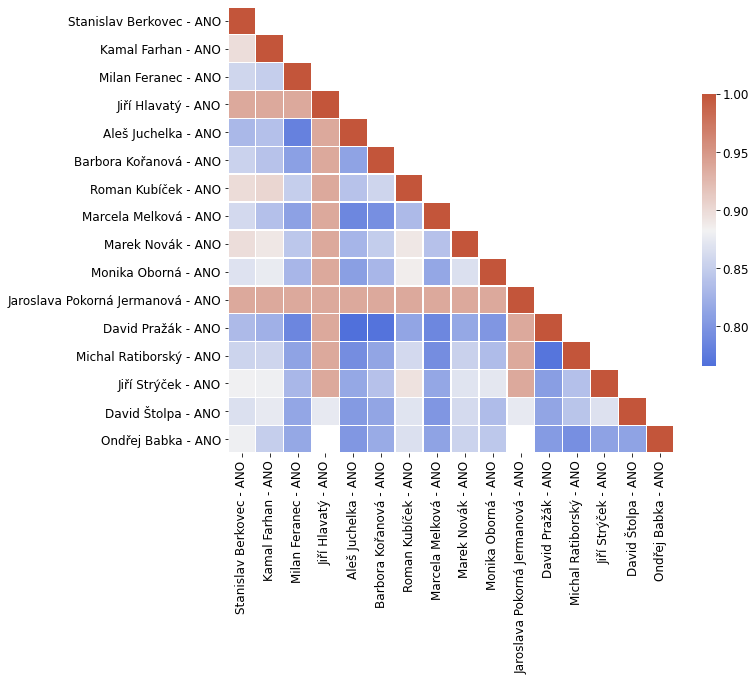

In [46]:
fig, ax = plt.subplots(figsize=(10, 10))

cmap = sns.diverging_palette(260, 20, as_cmap=True)
mask = np.triu(plot_8_data, 1)
sns.heatmap(plot_8_data, mask=mask, cmap=cmap, square=True, linewidths=0.5, cbar_kws={"shrink": .5})

plt.show()